# Compare trend from different methods

Using Durbin and Koopman 2012 as a Local Linear Trends, code-name PooBur-STK. See [State space modeling: Local Linear Trends in statsmodels](https://www.statsmodels.org/stable/examples/notebooks/generated/statespace_local_linear_trend.html)


In [1]:
import numpy as np
import pandas as pd
from pandas.testing import assert_frame_equal

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

from makhota import llt
from makhota import parameters
from makhota import utilities

sns.set()

In [2]:
# Parameters

country = 'Germany'
country = 'France'
# country = 'Italy'
#country = 'Singapore'

tags = ['confirmed_cases','deaths']
#tags = ['confirmed_cases', 'recovered_cases']

log_threshold = llt.log_threshold
lookahead_steps = llt.lookahead_steps
confidence=0.25

skip_days = 4

## Load data from file

In [3]:
global_time_series = utilities.load_latest_global_time_series()
global_time_series.tail()

place          Afghanistan                                Albania         \
tag        confirmed_cases deaths recovered_cases confirmed_cases deaths   
date                                                                       
2020-04-03           281.0    6.0            10.0           304.0   17.0   
2020-04-04           299.0    7.0            10.0           333.0   20.0   
2020-04-05           349.0    7.0            15.0           361.0   20.0   
2020-04-06           367.0   11.0            18.0           377.0   21.0   
2020-04-07           423.0   14.0            18.0           383.0   22.0   

place                              Algeria                         \
tag        recovered_cases confirmed_cases deaths recovered_cases   
date                                                                
2020-04-03            89.0          1171.0  105.0            62.0   
2020-04-04            99.0          1251.0  130.0            90.0   
2020-04-05           104.0          1320.0  152.0            90.0   
2020-04-06           116.0          1423.0  173.0            90.0   
2020-04-07           131.0          1468.0  193.0           113.0   

place              Andorra  ...          Zambia        Zimbabwe         \
tag        confirmed_cases  ... recovered_cases confirmed_cases deaths   
date                        ...                                          
2020-04-03           439.0  ...             2.0             9.0    1.0   
2020-04-04           466.0  ...             2.0             9.0    1.0   
2020-04-05           501.0  ...             3.0             9.0    1.0   
2020-04-06           525.0  ...             5.0            10.0    1.0   
2020-04-07           545.0  ...             7.0            11.0    2.0   

place                                World                           \
tag        recovered_cases confirmed_cases   deaths recovered_cases   
date                                                                  
2020-04-03             0.0       1095917.0  58787.0        225796.0   
2020-04-04             0.0       1197405.0  64606.0        246152.0   
2020-04-05             0.0       1272115.0  69374.0        260012.0   
2020-04-06             0.0       1345101.0  74565.0        276515.0   
2020-04-07             0.0       1426096.0  81865.0        300054.0   

place      World (ex China)                           
tag         confirmed_cases   deaths recovered_cases  
date                                                  
2020-04-03        1013406.0  55461.0        149036.0  
2020-04-04        1114862.0  61276.0        169206.0  
2020-04-05        1189513.0  66041.0        182805.0  
2020-04-06        1262436.0  71230.0        199205.0  
2020-04-07        1343378.0  78530.0        222644.0  

[5 rows x 798 columns]

In [4]:
global_time_series.index.freq

<Day>

In [5]:
local_series = global_time_series[country].copy()

local_series

tag         confirmed_cases   deaths  recovered_cases
date                                                 
2020-01-22              0.0      0.0              0.0
2020-01-23              0.0      0.0              0.0
2020-01-24              2.0      0.0              0.0
2020-01-25              3.0      0.0              0.0
2020-01-26              3.0      0.0              0.0
...                     ...      ...              ...
2020-04-03          64338.0   6507.0          14008.0
2020-04-04          89953.0   7560.0          15438.0
2020-04-05          92839.0   8078.0          16183.0
2020-04-06          98010.0   8911.0          17250.0
2020-04-07         109069.0  10328.0          19337.0

[77 rows x 3 columns]

## Compute trend tradtitionally

In [6]:
oneday_trend = local_series.pct_change().dropna().iloc[1:]

oneday_trend.tail(10)

tag         confirmed_cases    deaths  recovered_cases
date                                                  
2020-03-29         0.069168  0.126188         0.263509
2020-03-30         0.108926  0.160399         0.100666
2020-03-31         0.170101  0.165013         0.191371
2020-04-01         0.093251  0.144479         0.157772
2020-04-02         0.037130  0.336062         0.136638
2020-04-03         0.088537  0.207908         0.127132
2020-04-04         0.398132  0.161826         0.102085
2020-04-05         0.032083  0.068519         0.048258
2020-04-06         0.055699  0.103120         0.065933
2020-04-07         0.112835  0.159017         0.120986

### Five days running average

In [7]:
rolling_trend = local_series.pct_change().rolling(5).mean().dropna(how='all')

rolling_trend

tag         confirmed_cases    deaths  recovered_cases
date                                                  
2020-01-29         0.216667       NaN              NaN
2020-01-30         0.116667       NaN              NaN
2020-01-31         0.116667       NaN              NaN
2020-02-01         0.156667       NaN              NaN
2020-02-02         0.090000       NaN              NaN
...                     ...       ...              ...
2020-04-03         0.099589  0.202772         0.142716
2020-04-04         0.157430  0.203058         0.143000
2020-04-05         0.129827  0.183759         0.114377
2020-04-06         0.122316  0.175487         0.096009
2020-04-07         0.137457  0.140078         0.092879

[70 rows x 3 columns]

## Using the Local Linear Trend model

In [8]:
llt_trend = utilities.load_latest_hist_trend()[country].dropna(how='all')

llt_trend

confirmed_cases    deaths  recovered_cases
2020-02-20         0.007325       NaN              NaN
2020-02-21         0.006753       NaN              NaN
2020-02-22         0.006265       NaN              NaN
2020-02-23         0.005843       NaN              NaN
2020-02-24         0.005474       NaN              NaN
2020-02-25         0.021087       NaN              NaN
2020-02-26         0.330712       NaN              NaN
2020-02-27         2.037732       NaN              NaN
2020-02-28         0.885117       NaN              NaN
2020-02-29         1.025500       NaN              NaN
2020-03-01         0.477014       NaN              NaN
2020-03-02         0.527976       NaN              NaN
2020-03-03         0.160387       NaN              NaN
2020-03-04         0.345136       NaN              NaN
2020-03-05         0.393338       NaN              NaN
2020-03-06         0.859797       NaN              NaN
2020-03-07         0.694589       NaN              NaN
2020-03-08         0.297869       NaN     7.325223e-03
2020-03-09         0.097345       NaN     6.753178e-03
2020-03-10         0.394057       NaN     6.264690e-03
2020-03-11         0.357799       NaN     5.842978e-03
2020-03-12         0.135473       NaN     5.474221e-03
2020-03-13         0.403363       NaN     4.670294e-03
2020-03-14         0.333066       NaN     4.008691e-03
2020-03-15         0.170616       NaN     3.475022e-03
2020-03-16         0.320993       NaN     3.031635e-03
2020-03-17         0.257920       NaN     2.690446e-03
2020-03-18         0.232715       NaN     2.398409e-03
2020-03-19         0.228661  0.228685     2.129700e-03
2020-03-20         0.206059  0.353680     1.920736e-03
2020-03-21         0.178808  0.369135     1.742667e-03
2020-03-22         0.157413  0.363049     2.052279e+76
2020-03-23         0.199968  0.359402     1.395453e+02
2020-03-24         0.172960  0.356628     1.924622e+00
2020-03-25         0.159111  0.351018     9.730484e-01
2020-03-26         0.162307  0.347747     7.424877e-01
2020-03-27         0.153297  0.341343     5.878901e-01
2020-03-28         0.151802  0.333436     4.495943e-01
2020-03-29         0.118631  0.323866     4.177278e-01
2020-03-30         0.116260  0.281490     3.666526e-01
2020-03-31         0.142623  0.251398     3.411421e-01
2020-04-01         0.125317  0.224730     3.164004e-01
2020-04-02         0.088902  0.248395     2.929512e-01
2020-04-03         0.089405  0.251246     2.719215e-01
2020-04-04         0.214907  0.241290     2.508401e-01
2020-04-05         0.143323  0.213932     2.262054e-01
2020-04-06         0.109034  0.191207     2.173729e-01
2020-04-07         0.112163  0.182273     2.150843e-01

## Gather results togheter and plot for comparison

In [9]:
llt_trend.stack()

2020-02-20  confirmed_cases    0.007325
2020-02-21  confirmed_cases    0.006753
2020-02-22  confirmed_cases    0.006265
2020-02-23  confirmed_cases    0.005843
2020-02-24  confirmed_cases    0.005474
                                 ...   
2020-04-06  deaths             0.191207
            recovered_cases    0.217373
2020-04-07  confirmed_cases    0.112163
            deaths             0.182273
            recovered_cases    0.215084
Length: 99, dtype: float64

In [10]:
lll_col = 'C: local log-linear filter'

In [11]:
cmp_trend = pd.DataFrame({
    'A: one-day trend': oneday_trend.stack(),
    'B: 5-day moving average': rolling_trend.stack(),
    lll_col: llt_trend.stack(),    
}).unstack().dropna(axis='index').swaplevel(axis='columns').sort_index(axis='columns')

cmp_trend

confirmed_cases                          \
           A: one-day trend B: 5-day moving average   
2020-03-19         0.202145                0.203719   
2020-03-20         0.160151                0.234406   
2020-03-21         0.132414                0.166024   
2020-03-22         0.121552                0.159609   
2020-03-23         0.239605                0.171173   
2020-03-24         0.123288                0.155402   
2020-03-25         0.131322                0.149636   
2020-03-26         0.155431                0.154240   
2020-03-27         0.130647                0.156059   
2020-03-28         0.139880                0.136113   
2020-03-29         0.069168                0.125290   
2020-03-30         0.108926                0.120810   
2020-03-31         0.170101                0.123744   
2020-04-01         0.093251                0.116265   
2020-04-02         0.037130                0.095715   
2020-04-03         0.088537                0.099589   
2020-04-04         0.398132                0.157430   
2020-04-05         0.032083                0.129827   
2020-04-06         0.055699                0.122316   
2020-04-07         0.112835                0.137457   

                                                deaths  \
           C: local log-linear filter A: one-day trend   
2020-03-19                   0.228661         0.641892   
2020-03-20                   0.206059         0.851852   
2020-03-21                   0.178808         0.248889   
2020-03-22                   0.157413         0.199288   
2020-03-23                   0.199968         0.275964   
2020-03-24                   0.172960         0.279070   
2020-03-25                   0.159111         0.210000   
2020-03-26                   0.162307         0.274230   
2020-03-27                   0.153297         0.176297   
2020-03-28                   0.151802         0.159900   
2020-03-29                   0.118631         0.126188   
2020-03-30                   0.116260         0.160399   
2020-03-31                   0.142623         0.165013   
2020-04-01                   0.125317         0.144479   
2020-04-02                   0.088902         0.336062   
2020-04-03                   0.089405         0.207908   
2020-04-04                   0.214907         0.161826   
2020-04-05                   0.143323         0.068519   
2020-04-06                   0.109034         0.103120   
2020-04-07                   0.112163         0.159017   

                                                               \
           B: 5-day moving average C: local log-linear filter   
2020-03-19                0.253653                   0.228685   
2020-03-20                0.424023                   0.353680   
2020-03-21                0.348527                   0.369135   
2020-03-22                0.388384                   0.363049   
2020-03-23                0.443577                   0.359402   
2020-03-24                0.371013                   0.356628   
2020-03-25                0.242642                   0.351018   
2020-03-26                0.247710                   0.347747   
2020-03-27                0.243112                   0.341343   
2020-03-28                0.219899                   0.333436   
2020-03-29                0.189323                   0.323866   
2020-03-30                0.179403                   0.281490   
2020-03-31                0.157560                   0.251398   
2020-04-01                0.151196                   0.224730   
2020-04-02                0.186428                   0.248395   
2020-04-03                0.202772                   0.251246   
2020-04-04                0.203058                   0.241290   
2020-04-05                0.183759                   0.213932   
2020-04-06                0.175487                   0.191207   
2020-04-07                0.140078                   0.182273   

            recovered_cases                                                     
           A

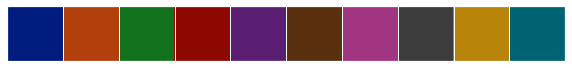

In [12]:
palette_name = 'dark'

sns.set_palette(palette_name)

sns.palplot(sns.color_palette(palette_name))

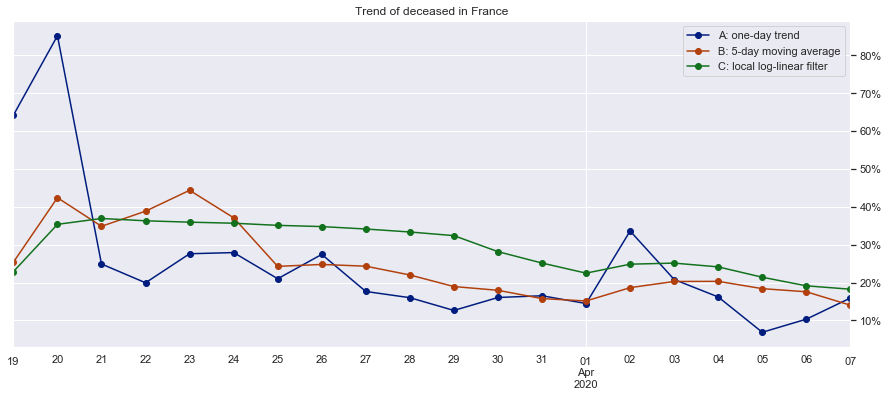

In [13]:
ax = cmp_trend['deaths'].plot(title=f"Trend of deceased in {country}", 
                         figsize=(15,6), marker='o')

ax.yaxis.tick_right()
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 


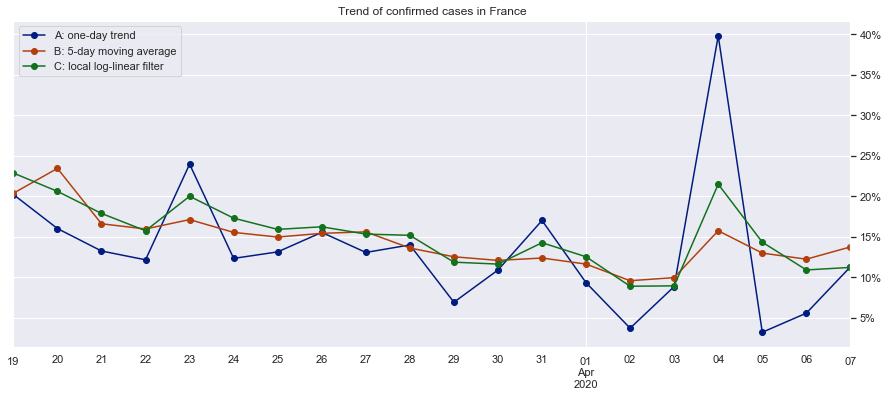

In [14]:
ax =cmp_trend['confirmed_cases'].plot(title=f"Trend of confirmed cases in {country}", 
                                      figsize=(15,6), marker='o', colormap=None)

ax.yaxis.tick_right()
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 


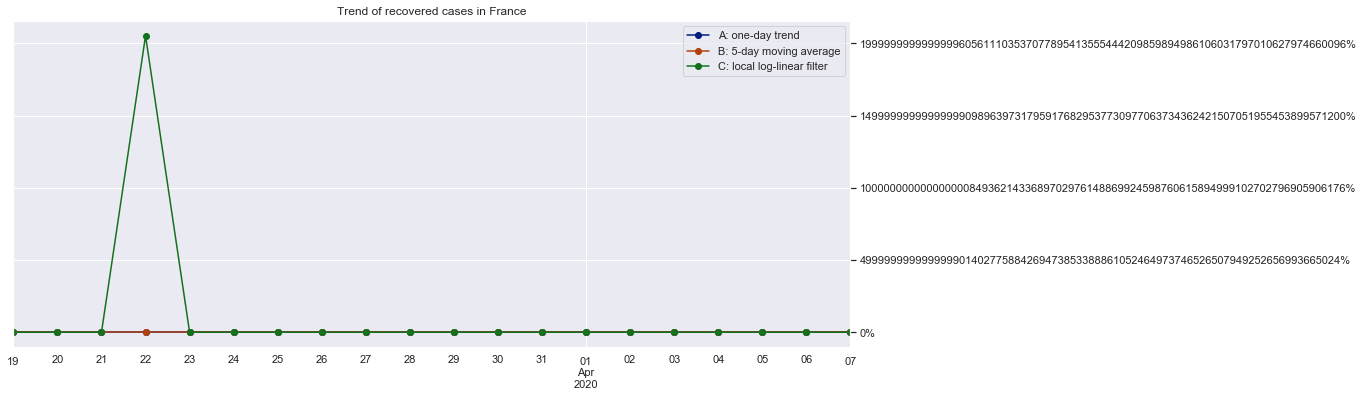

In [15]:
ax=cmp_trend['recovered_cases'].plot(title=f"Trend of recovered cases in {country}", 
                                  figsize=(15,6), marker='o')

ax.yaxis.tick_right()
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 

### One-step finite-diffrence convexity

In [16]:
convexity_1_step = cmp_trend - cmp_trend.shift()

act_convexity_1_step = llt.one_step_right_slope(cmp_trend)

assert_frame_equal(act_convexity_1_step, convexity_1_step)

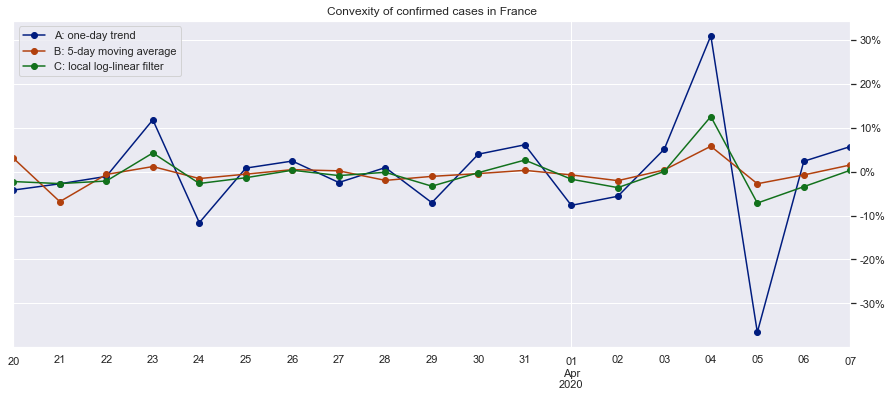

In [17]:
ax = convexity_1_step['confirmed_cases'].loc['2020-03-20':].plot(title=f"Convexity of confirmed cases in {country}", 
                                         figsize=(15,6), marker='o')

ax.yaxis.tick_right()
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 


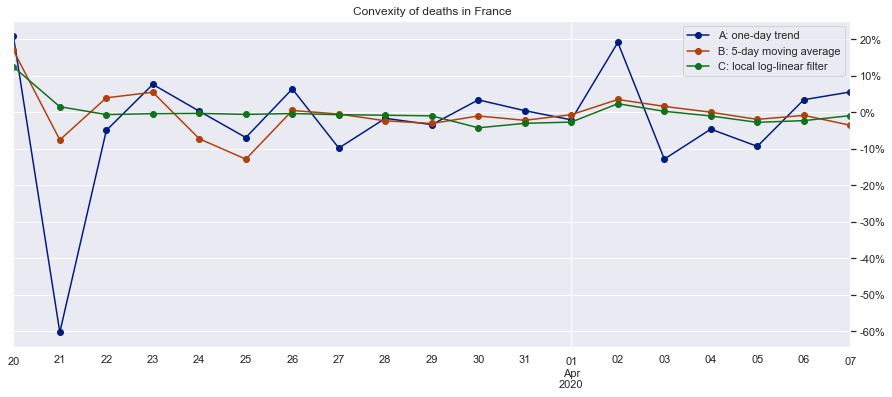

In [18]:
ax = convexity_1_step['deaths'].loc['2020-03-20':].plot(title=f"Convexity of deaths in {country}", 
                                         figsize=(15,6), marker='o')
ax.yaxis.tick_right()
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 

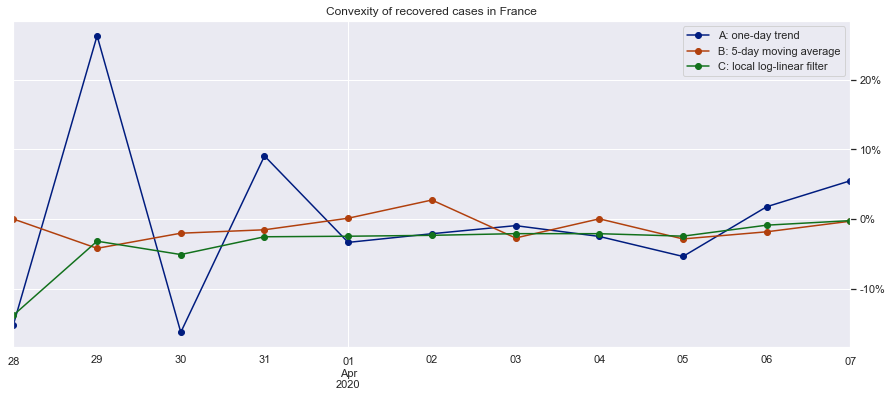

In [19]:
ax = convexity_1_step['recovered_cases'].loc['2020-03-28':].plot(title=f"Convexity of recovered cases in {country}", 
                                         figsize=(15,6), marker='o')
ax.yaxis.tick_right()
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 


### Two-step finite-diffrence convexity

In [20]:
convexity_2_step = cmp_trend *2.0/3.0 - cmp_trend.shift()/3.0  - cmp_trend.shift().shift()/3.0

act_convexity_2_step = llt.two_steps_right_slope(cmp_trend)

assert_frame_equal(act_convexity_2_step, convexity_2_step)

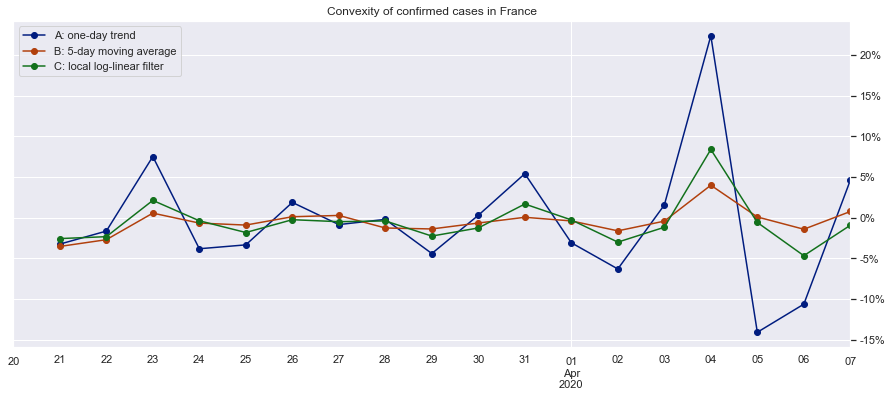

In [21]:
ax = convexity_2_step['confirmed_cases'].loc['2020-03-20':].plot(title=f"Convexity of confirmed cases in {country}", 
                                                                 figsize=(15,6), marker='o')

ax.yaxis.tick_right()
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 

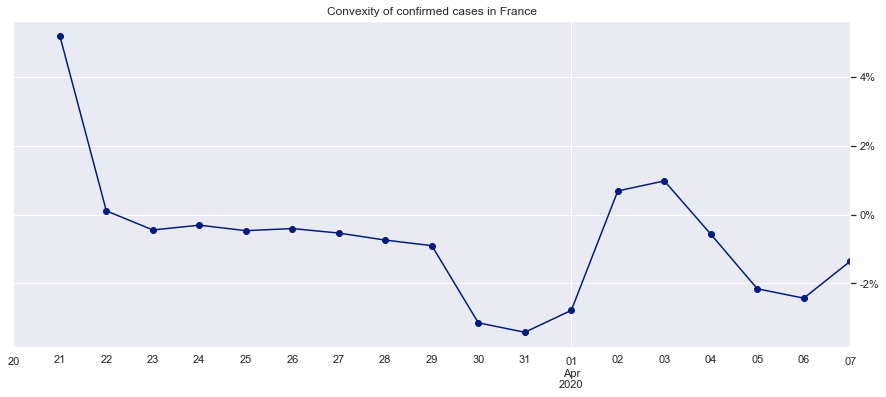

In [22]:
ax = convexity_2_step['deaths'][lll_col].loc['2020-03-20':] \
            .plot(title=f"Convexity of confirmed cases in {country}", 
                         figsize=(15,6), marker='o')
ax.yaxis.tick_right()
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 

### Three-step finite-diffrence convexity

In [23]:
convexity_3_step = cmp_trend/2.0 - cmp_trend.shift()/6.0 \
                     - cmp_trend.shift().shift()/6.0 - cmp_trend.shift().shift().shift()/6.0


act_convexity_3_step = llt.three_steps_right_slope(cmp_trend)

assert_frame_equal(act_convexity_3_step, convexity_3_step)

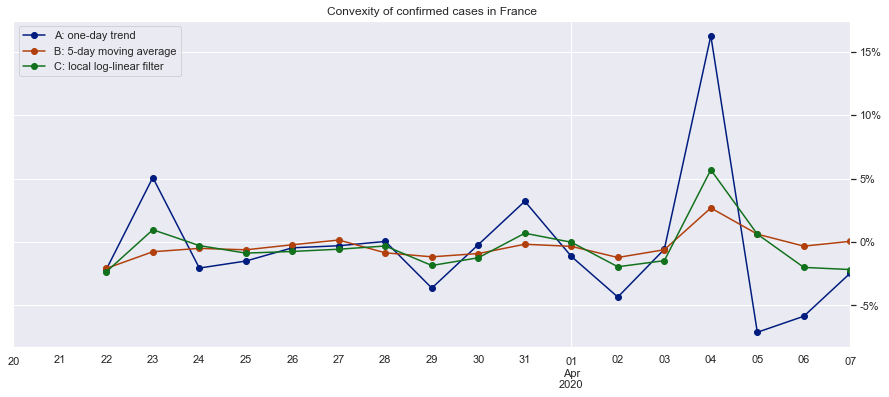

In [24]:
ax = convexity_3_step['confirmed_cases'].loc['2020-03-20':].plot(title=f"Convexity of confirmed cases in {country}", 
                                         figsize=(15,6), marker='o')

ax.yaxis.tick_right()
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 


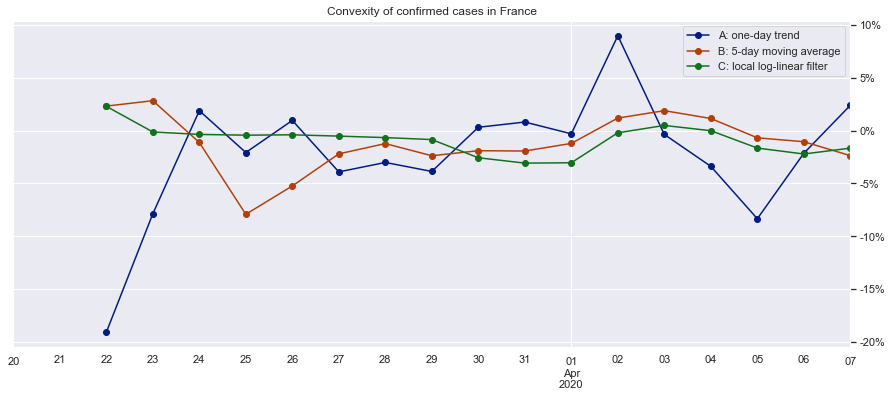

In [25]:
ax = convexity_3_step['deaths'].loc['2020-03-20':].plot(title=f"Convexity of confirmed cases in {country}", 
                                         figsize=(15,6), marker='o')

ax.yaxis.tick_right()
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 


## Other comparison

In [26]:
cmp_steps=pd.DataFrame({
    '1_step': convexity_1_step.swaplevel(axis='columns').sort_index(axis='columns')[lll_col].stack(),
    '2_step': convexity_2_step.swaplevel(axis='columns').sort_index(axis='columns')[lll_col].stack(),
    '3_step': convexity_3_step.swaplevel(axis='columns').sort_index(axis='columns')[lll_col].stack(),
}).unstack().dropna(axis='index').swaplevel(axis='columns').sort_index(axis='columns')

cmp_steps

confirmed_cases                        deaths                      \
                    1_step    2_step    3_step    1_step    2_step    3_step   
2020-03-22       -0.021395 -0.023347 -0.023548 -0.006086  0.001094  0.022941   
2020-03-23        0.042555  0.021238  0.009604 -0.003647 -0.004460 -0.001276   
2020-03-24       -0.027008 -0.003820 -0.002885 -0.002774 -0.003065 -0.003617   
2020-03-25       -0.013849 -0.018235 -0.008835 -0.005610 -0.004665 -0.004338   
2020-03-26        0.003196 -0.002486 -0.007520 -0.003271 -0.004050 -0.003968   
2020-03-27       -0.009009 -0.004941 -0.005748 -0.006404 -0.005359 -0.005227   
2020-03-28       -0.001496 -0.004000 -0.003218 -0.007907 -0.007406 -0.006633   
2020-03-29       -0.033171 -0.022612 -0.018585 -0.009570 -0.009016 -0.008488   
2020-03-30       -0.002371 -0.012638 -0.012492 -0.042376 -0.031441 -0.025696   
2020-03-31        0.026363  0.016785  0.006863 -0.030092 -0.034187 -0.030766   
2020-04-01       -0.017307 -0.002750 -0.000261 -0.026668 -0.027809 -0.030427   
2020-04-02       -0.036414 -0.030045 -0.019582  0.023665  0.006887 -0.002072   
2020-04-03        0.000503 -0.011803 -0.014771  0.002850  0.009789  0.004869   
2020-04-04        0.125501  0.083835  0.056849 -0.009956 -0.005687 -0.000084   
2020-04-05       -0.071584 -0.005889  0.006126 -0.027358 -0.021557 -0.016523   
2020-04-06       -0.034288 -0.046720 -0.020089 -0.022725 -0.024269 -0.022141   
2020-04-07        0.003129 -0.009343 -0.021796 -0.008934 -0.013531 -0.016602   

           recovered_cases                              
                    1_step        2_step        3_step  
2020-03-22    2.052279e+76  1.368186e+76  1.026139e+76  
2020-03-23   -2.052279e+76 -6.840930e+75 -3.420465e+75  
2020-03-24   -1.376207e+02 -6.840930e+75 -3.420465e+75  
2020-03-25   -9.515733e-01 -4.650795e+01 -3.420465e+75  
2020-03-26   -2.305607e-01 -4.708982e-01 -2.336926e+01  
2020-03-27   -1.545976e-01 -1.799186e-01 -3.127479e-01  
2020-03-28   -1.382958e-01 -1.437297e-01 -1.591072e-01  
2020-03-29   -3.186657e-02 -6.734298e-02 -8.779815e-02  
2020-03-30   -5.107520e-02 -4.467232e-02 -5.920909e-02  
2020-03-31   -2.551047e-02 -3.403205e-02 -3.509140e-02  
2020-04-01   -2.474169e-02 -2.499795e-02 -2.938687e-02  
2020-04-02   -2.344921e-02 -2.388004e-02 -2.422358e-02  
2020-04-03   -2.102969e-02 -2.183620e-02 -2.245486e-02  
2020-04-04   -2.108140e-02 -2.106416e-02 -2.145880e-02  
2020-04-05   -2.463468e-02 -2.345025e-02 -2.284942e-02  
2020-04-06   -8.832518e-03 -1.409991e-02 -1.614139e-02  
2020-04-07   -2.288629e-03 -4.469925e-03 -8.194267e-03

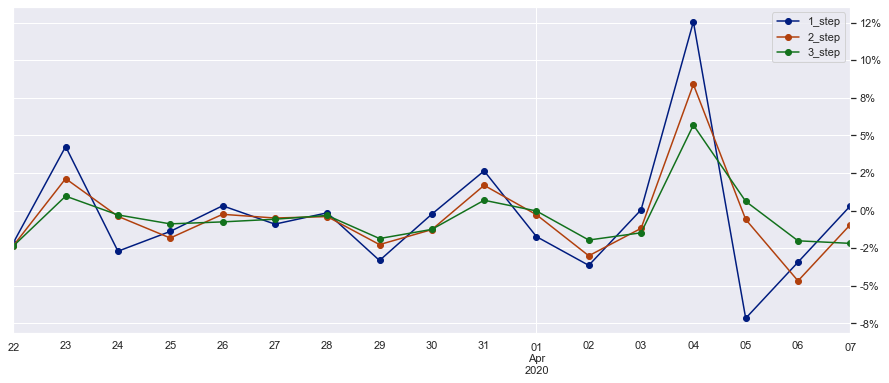

In [27]:
ax =cmp_steps['confirmed_cases'].loc['2020-03-16':].plot(figsize=(15,6), marker='o')

ax.yaxis.tick_right()
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 

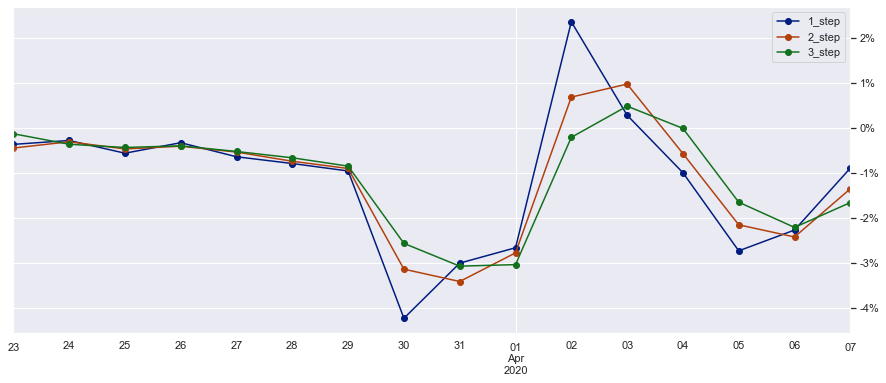

In [28]:
ax =cmp_steps['deaths'].loc['2020-03-23':].plot(figsize=(15,6), marker='o')

ax.yaxis.tick_right()
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 

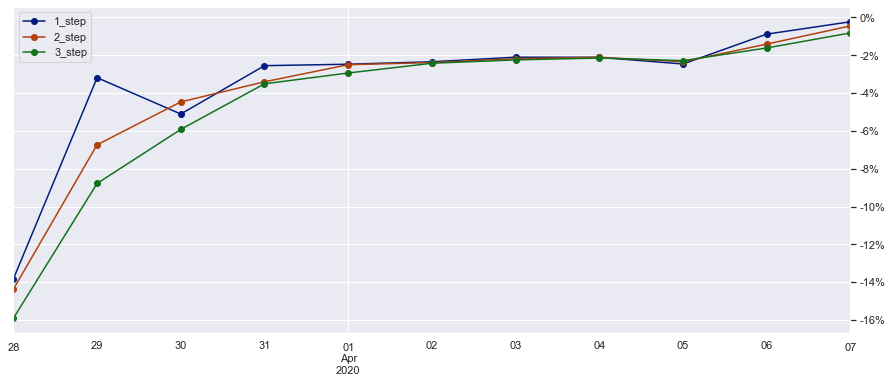

In [29]:
ax =cmp_steps['recovered_cases'].loc['2020-03-28':].plot(figsize=(15,6), marker='o')

ax.yaxis.tick_right()
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 